# Test Clustering Algorithms

This notebook tests a two clustering algorithms for each region using modules from spark.ml.clustering. Additionally, plots were created to plot clusters with the highest fatality rates in each region.

The two clustering algorithms tested are:
1. KMeans
2. Gaussian Mixture Modeling (GMM)

The Notebook is broken down into three sections:

**Section 1:**

Load data using spark

**Section 2:**

Test the Kmeans and GMM across the 4 regions using spark, and plot and compute the fatality rates of each cluster

In [1]:
import sys
from pathlib import Path
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType

# get root directory of project
ROOT_DIR = Path.cwd().parent

# Add the root directory to sys.path
sys.path.append(str(ROOT_DIR))

from src.spark_clustering import CrashDataProcessor, CentroidClusterData

# Initialize Spark session with AWS credentials
DATA_DIR = ROOT_DIR / 'data' / 'processed_spark_data'
PLOTS_DIR = ROOT_DIR / 'data' / 'plots'
print(f"DATA_DIR: {DATA_DIR}")

# Initialize Spark session
conf = SparkConf().setAppName("CrashDataProcessor").setMaster("local")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.appName("CrashDataProcessor").getOrCreate()

DATA_DIR: /home/jovyan/Final_Project/data/processed_spark_data


## Section 1

**Load the Crash Data**

In [2]:
# define schema for CSV files (assuming all columns are strings for simplicity)
schema = StructType([StructField(str(i), StringType(), True) for i in range(12)])

# read CSV files into DataFrames without headers
boerne_df = spark.read.csv(str(DATA_DIR / 'boerne_crash_data.csv'), schema=schema, header=False)
austin_df = spark.read.csv(str(DATA_DIR / 'austin_crash_data.csv'), schema=schema, header=False)
downtown_san_antonio_df = spark.read.csv(str(DATA_DIR / 'north_san_antonio_crash_data.csv'), schema=schema, header=False)
sugarland_df = spark.read.csv(str(DATA_DIR / 'sugarland_crash_data.csv'), schema=schema, header=False)

View Boerne Crash Data

In [3]:
boerne_df.take(3)

[Row(0='17031755', 1='N', 2='4/24/2019', 3='29.75398566', 4='-98.70434216', 5='0', 6='0', 7='1', 8='1', 9='0', 10='1', 11='0'),
 Row(0='17032188', 1='N', 2='4/25/2019', 3='29.79568653', 4='-98.73270632', 5='0', 6='0', 7='0', 8='2', 9='0', 10='0', 11='0'),
 Row(0='17032211', 1='N', 2='4/25/2019', 3='29.76116059', 4='-98.71249245', 5='0', 6='0', 7='0', 8='2', 9='0', 10='0', 11='0')]

View Austin Crash Data

In [4]:
austin_df.take(3)

[Row(0='17029759', 1='N', 2='4/24/2019', 3='30.29412477', 4='-97.70778247', 5='0', 6='1', 7='0', 8='1', 9='0', 10='1', 11='0'),
 Row(0='17029763', 1='N', 2='4/24/2019', 3='30.32190717', 4='-97.7075925', 5='0', 6='0', 7='0', 8='1', 9='0', 10='0', 11='0'),
 Row(0='17029849', 1='N', 2='4/24/2019', 3='30.30018477', 4='-97.64826249', 5='0', 6='0', 7='0', 8='4', 9='0', 10='0', 11='0')]

View Downtown San Antonio Crash Data

In [5]:
downtown_san_antonio_df.take(3)

[Row(0='17030974', 1='N', 2='4/24/2019', 3='29.41041811', 4='-98.4798075', 5='0', 6='0', 7='0', 8='3', 9='0', 10='0', 11='0'),
 Row(0='17031991', 1='N', 2='4/24/2019', 3='29.42738497', 4='-98.49448231', 5='0', 6='0', 7='2', 8='3', 9='0', 10='2', 11='0'),
 Row(0='17032423', 1='N', 2='4/24/2019', 3='29.42116497', 4='-98.49090231', 5='0', 6='0', 7='0', 8='2', 9='2', 10='0', 11='0')]

View Sugarland Crash Data

In [6]:
sugarland_df.take(3)

[Row(0='17030052', 1='N', 2='4/24/2019', 3='29.58257535', 4='-95.56345092', 5='0', 6='0', 7='0', 8='2', 9='0', 10='0', 11='0'),
 Row(0='17030918', 1='N', 2='4/24/2019', 3='29.64431532', 4='-95.65159988', 5='0', 6='0', 7='0', 8='1', 9='1', 10='0', 11='0'),
 Row(0='17031598', 1='N', 2='4/24/2019', 3='29.59242555', 4='-95.6059395', 5='0', 6='0', 7='2', 8='1', 9='0', 10='2', 11='0')]

## Section 2

Test the K-Means and Hierarchical Clustering across the 4 regions using spark and compute fatality rates of each cluster.

**K-Means Clustering for Boerne, TX**

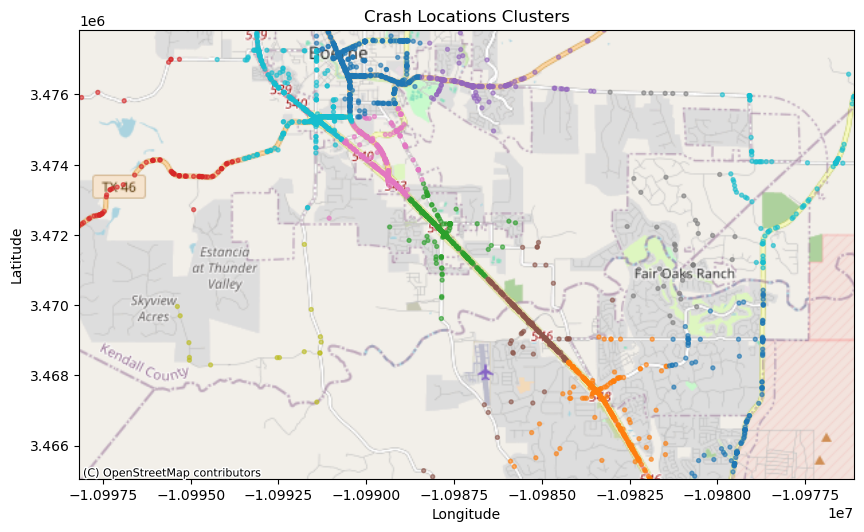

In [7]:
plots_path = PLOTS_DIR / 'kmeans_boerne.png'

boerne_crashes = CrashDataProcessor(boerne_df)

# model k-means
boerne_crashes = boerne_crashes.assemble_features()
boerne_clustered = boerne_crashes.KMeans_model()
boerne_clustered.plot_clusters(cluster_column='kmeans_cluster', save_path=plots_path)

**Compute and plot fatality rates**

In [8]:
s3_path = 's3://txdot-crash-data-rice/clean-data/'

fatality_rate = boerne_clustered.compute_fatality_rate(cluster_col='kmeans_cluster',
                                                       save_to_s3=True, 
                                                       s3_path=s3_path)
fatality_rate.orderBy('Fatality_Rate', ascending=False).take(3)

[Row(kmeans_cluster=8, centroid_latitude=29.75586158052631, centroid_longitude=-98.64609892342105, fatality_rate=0.05263157894736842),
 Row(kmeans_cluster=4, centroid_latitude=29.767910304868415, centroid_longitude=-98.77779337342106, fatality_rate=0.039473684210526314),
 Row(kmeans_cluster=2, centroid_latitude=29.716938150553855, centroid_longitude=-98.6639883868308, fatality_rate=0.009230769230769232)]

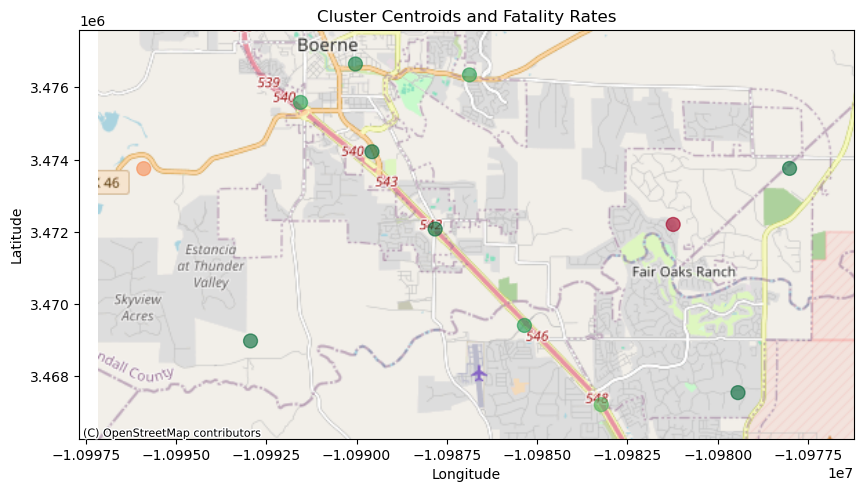

In [11]:
plots_path = PLOTS_DIR / 'kmeans_fatality_boerne.png'
fatality_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(save_path=plots_path)

**K-Means Clustering for Downtown San Antonio, TX**

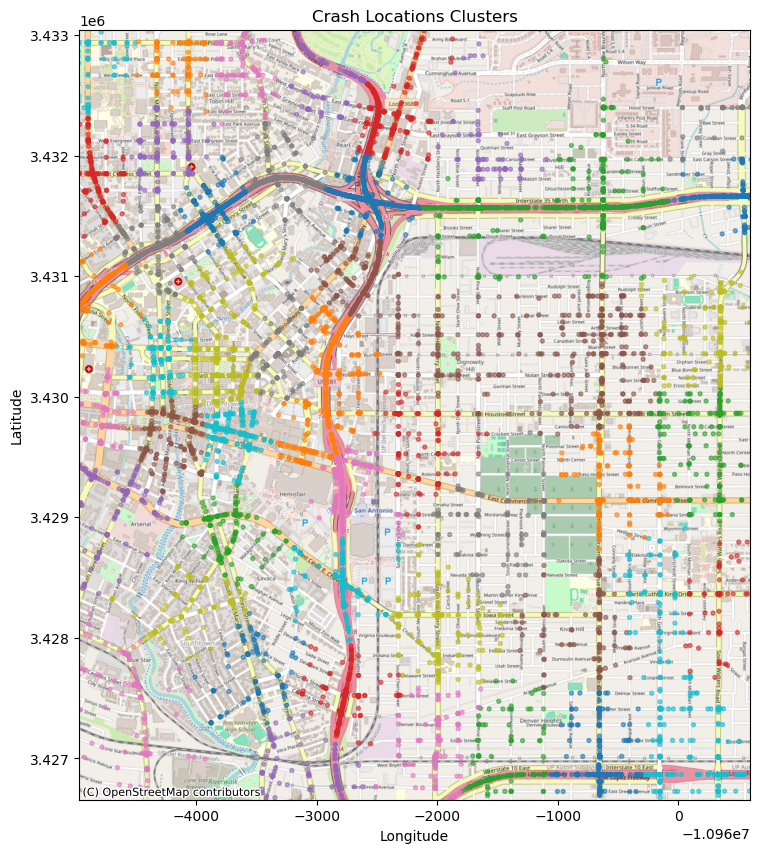

In [13]:
downtown_sa_crashes = CrashDataProcessor(downtown_san_antonio_df)

# model k-means
downtown_sa_crashes = downtown_sa_crashes.assemble_features()
downtown_sa_clustered = downtown_sa_crashes.KMeans_model()
downtown_sa_clustered.plot_clusters(cluster_column='kmeans_cluster', zoom=15)

**Compute and plot fatality rates**

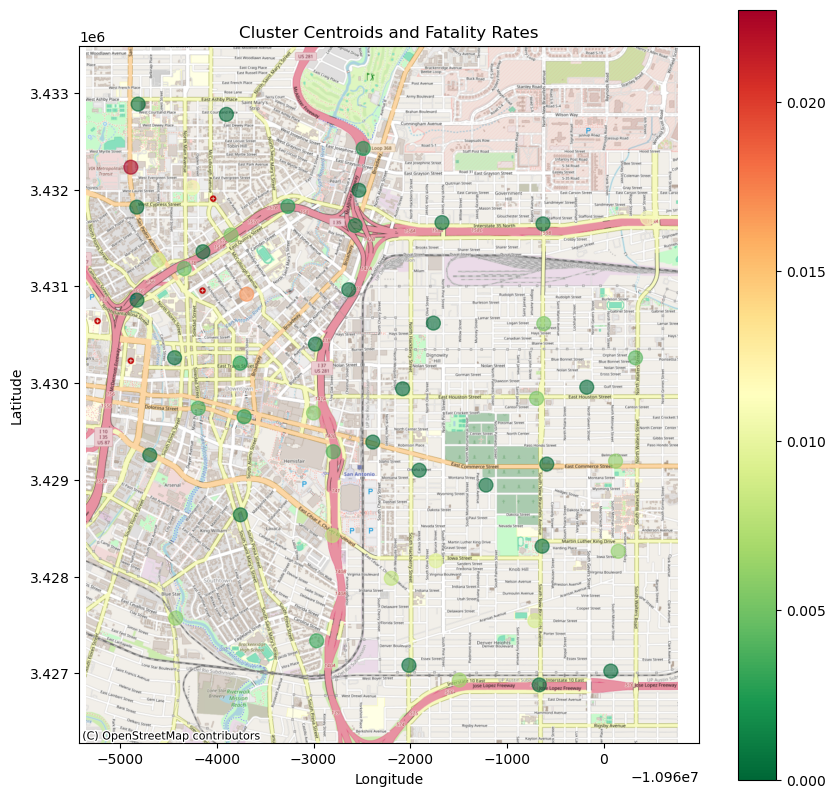

In [11]:
fatality_rate = downtown_sa_clustered.compute_fatality_rate(cluster_col='kmeans_cluster')
fatal`ity_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(zoom=15)

**K-Means Clustering for Sugarland, TX**

In [ ]:
sugarland_crashes = CrashDataProcessor(sugarland_df)

# model k-means
sugarland_crashes = sugarland_crashes.assemble_features()
sugarland_clustered = sugarland_crashes.KMeans_model()
sugarland_clustered.plot_clusters(cluster_column='kmeans_cluster', zoom=15)

**Compute and plot fatality rates**

In [ ]:
fatality_rate = sugarland_clustered.compute_fatality_rate(cluster_col='kmeans_cluster')
fatality_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(zoom=15)

**K-Means Clustering for Austin, TX**

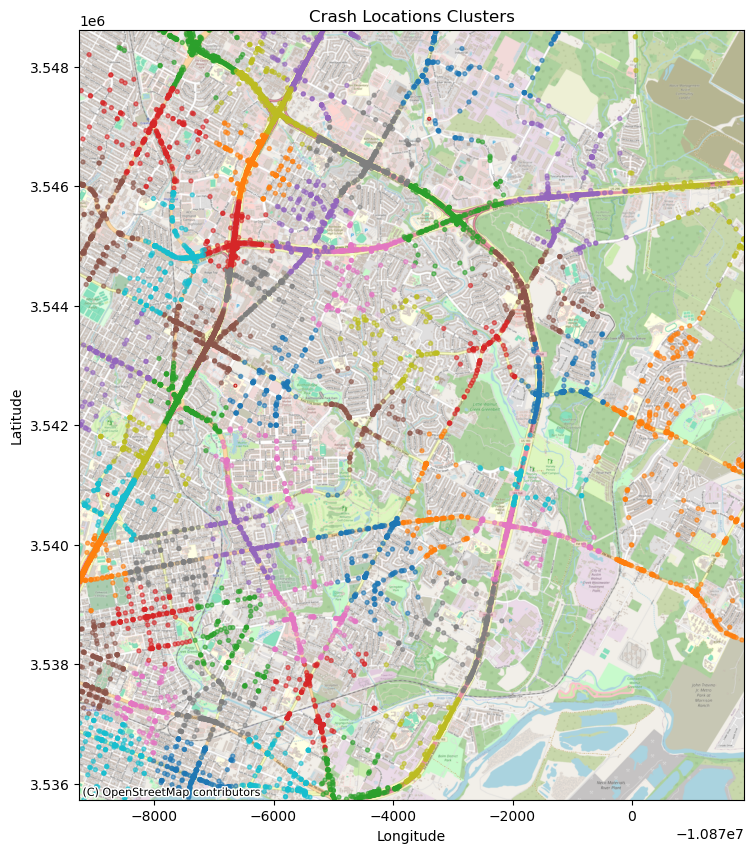

In [11]:
austin_crashes = CrashDataProcessor(austin_df)

# model K-means
austin_crashes = austin_crashes.assemble_features()
austin_clustered = austin_crashes.KMeans_model()
austin_clustered.plot_clusters(cluster_column='kmeans_cluster', zoom=15)

**Compute and plot fatality rates**

In [ ]:
fatality_rate = austin_clustered.compute_fatality_rate(cluster_col='kmeans_cluster')
fatality_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(zoom=15)

## Perform GMM Clustering

**GMM Clustering for Boerne, TX**

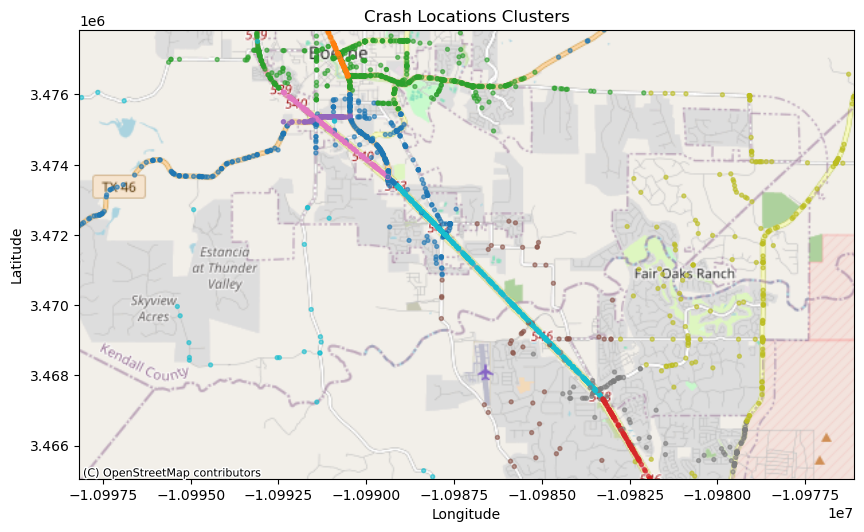

In [6]:
plots_path = PLOTS_DIR / 'GMM_boerne.png'

boerne_gmm = boerne_crashes.GMM_model()
boerne_gmm.plot_clusters(cluster_column='GMM_cluster', save_path=plots_path)

**Compute and plot fatality rates**

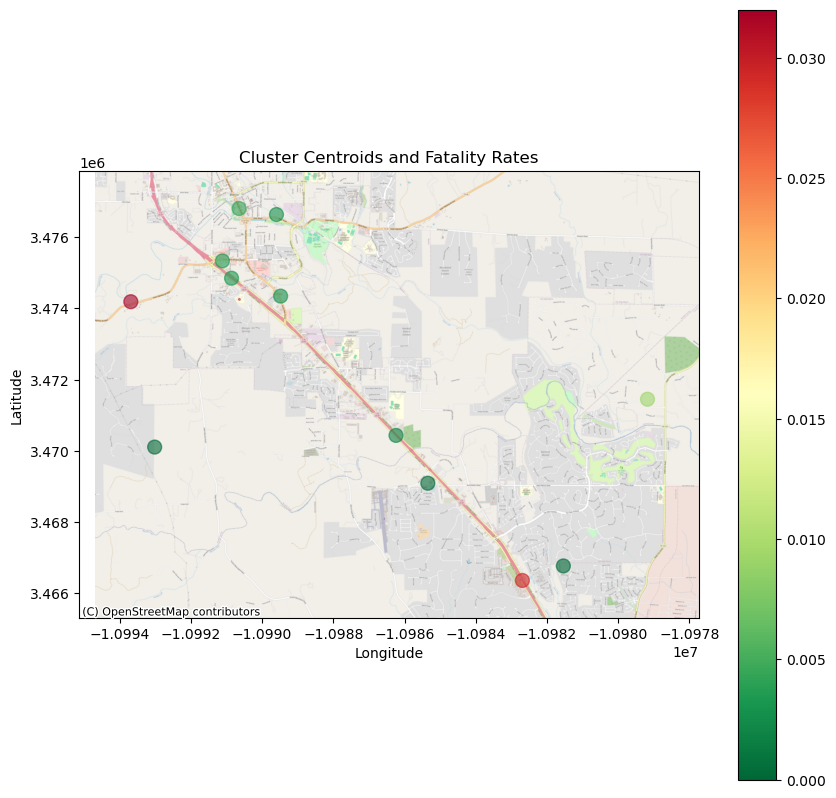

In [7]:
fatality_rate = boerne_gmm.compute_fatality_rate(cluster_col='GMM_cluster')
fatality_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(zoom=15)

**GMM Clustering for Downtown San Antonio, TX**

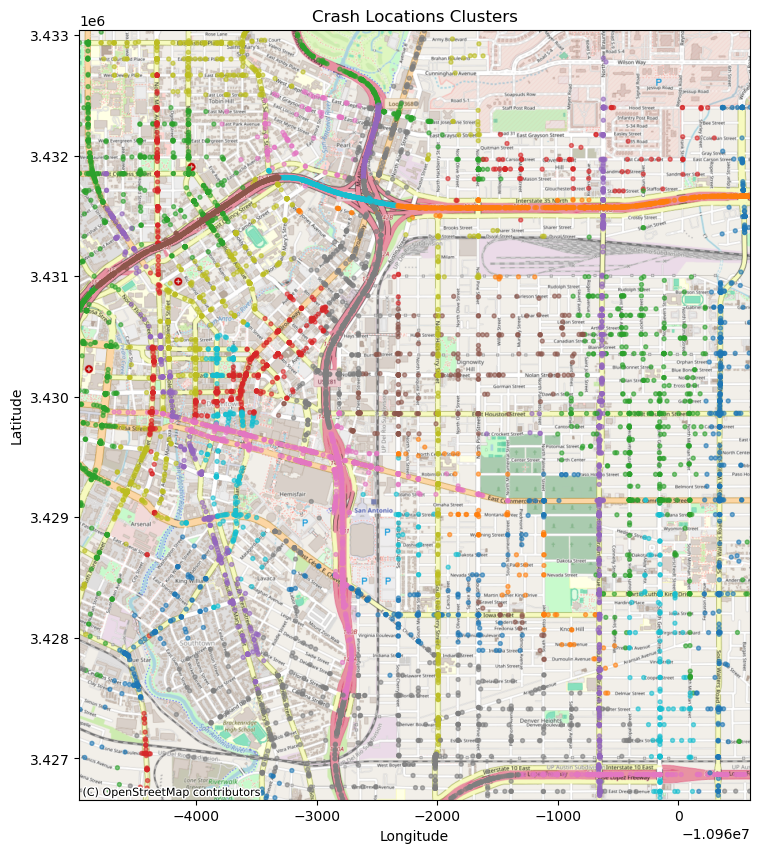

In [14]:
downtown_sa_gmm = downtown_sa_crashes.GMM_model()
downtown_sa_gmm.plot_clusters(cluster_column='GMM_cluster', zoom=15)

**Compute and plot fatality rates**

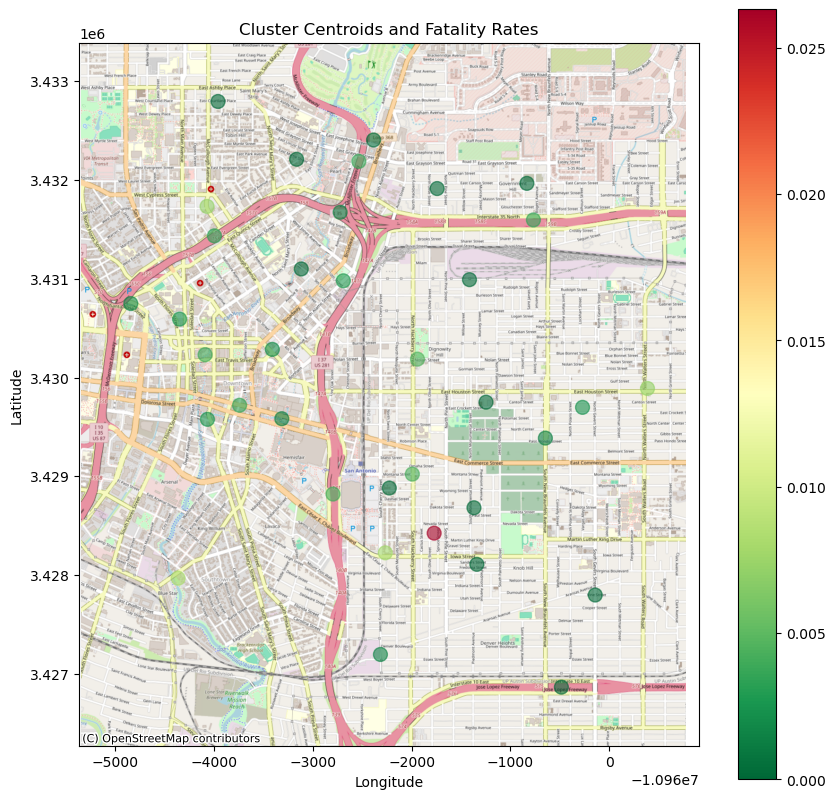

In [15]:
fatality_rate = downtown_sa_gmm.compute_fatality_rate(cluster_col='GMM_cluster')
fatality_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(zoom=15)

**GMM Clustering for Sugarland, TX**

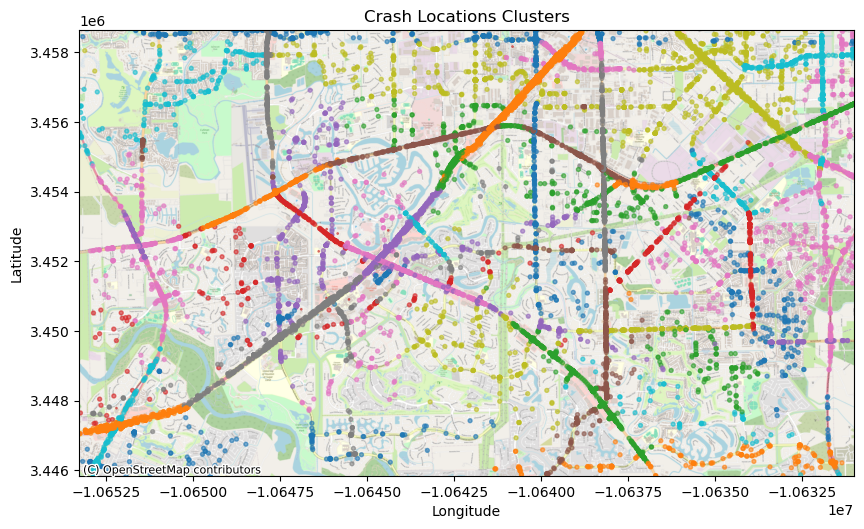

In [14]:
sugarland_gmm = sugarland_crashes.GMM_model()
sugarland_gmm.plot_clusters(cluster_column='GMM_cluster', zoom=15)

**Compute and plot fatality rates**

In [ ]:
fatality_rate = sugarland_gmm.compute_fatality_rate(cluster_col='GMM_cluster')
fatality_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(zoom=15)

**GMM Clustering for Austin, TX**

In [ ]:
austin_gmm = austin_crashes.GMM_model()
austin_gmm.plot_clusters(cluster_column='GMM_cluster', zoom=15)

**Compute and plot fatality rates**

In [ ]:
fatality_rate = austin_gmm.compute_fatality_rate(cluster_col='GMM_cluster')
fatality_rate_clusters = CentroidClusterData(fatality_rate)
fatality_rate_clusters.plot_fatality_rate(zoom=15)